In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

spark = SparkSession.builder.appName("Pysparkquestions").master("local[*]").getOrCreate()
spark

schema = StructType([ 
 StructField("ActorId",IntegerType(),True), 
 StructField("DirectorId",IntegerType(),True), 
 StructField("timestamp",IntegerType(),True) 
]) 
  
data = [ 
 (1, 1, 0), 
 (1, 1, 1), 
 (1, 1, 2), 
 (1, 2, 3), 
 (1, 2, 4), 
 (2, 1, 5), 
 (2, 1, 6) 
] 
df = spark.createDataFrame(data = data,schema =schema)
df.show()

df_grouped = df.groupBy("ActorId","DirectorId").count()
df_grouped.filter(df_grouped["count"]>=3).select("ActorId","DirectorId").show()

+-------+----------+---------+
|ActorId|DirectorId|timestamp|
+-------+----------+---------+
|      1|         1|        0|
|      1|         1|        1|
|      1|         1|        2|
|      1|         2|        3|
|      1|         2|        4|
|      2|         1|        5|
|      2|         1|        6|
+-------+----------+---------+

+-------+----------+
|ActorId|DirectorId|
+-------+----------+
|      1|         1|
+-------+----------+



In [2]:
from pyspark.sql import SparkSession

from pyspark.sql.types import *
from pyspark.sql.functions import *

spark = SparkSession.builder.appName("Pyspark_handson").master("local[*]").getOrCreate()

df = spark.read.format("csv").option("inferSchema",True).option("header",True).load("Data/Workersdata.csv")
df.filter(df["Department"]=='HR').withColumnRenamed("Department","Hrdept").show()

+-------+------+------+
|   Name|Hrdept|Salary|
+-------+------+------+
|  Alice|    HR| 50000|
|Charlie|    HR| 55000|
+-------+------+------+



In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField,StringType,IntegerType
from pyspark.sql.functions import concat,lit,col,substring,length,regexp_replace

spark = SparkSession.builder.appName("maskingPIP").master("local[*]").getOrCreate()

data = ([
    (1,"CaptainAmerica","CaptainAmerica22@gmail.com"),
    (2,"johnFlink","johnFlink22@gmail.com"),
    (3,"doeram","doeram22@gmail.com"),
    (4,"RobertDowney","RobertDowney22@gmail.com"),
    (5,"JackSparrow","JackSparrow32@gmail.com")
])

schema = StructType([
    StructField("Id",IntegerType(),False),
    StructField("Name",StringType(),True),
    StructField("Email",StringType(),True) 
])

df = spark.createDataFrame(data = data, schema = schema)

df1 = df.withColumn("maskedName",concat(lit("*****"),expr("substring(Name,5,length(Name)-4)")))\
        .withColumn("maskedEmail",regexp_replace(col("Email"),r'(?<=.).(?=[^@]*?@)','x'))

        #.withColumn("maskedName",regexp_replace(col("Name"),r'(?<=.).','x'))\

df1.show(truncate = False)

+---+--------------+--------------------+
| Id|          Name|               Email|
+---+--------------+--------------------+
|  1|CaptainAmerica|CaptainAmerica22@...|
|  2|     johnFlink|johnFlink22@gmail...|
|  3|        doeram|  doeram22@gmail.com|
|  4|  RobertDowney|RobertDowney22@gm...|
|  5|   JackSparrow|JackSparrow32@gma...|
+---+--------------+--------------------+



𝐐𝐮𝐞𝐬𝐭𝐢𝐨𝐧:
Problem Statement:
For a given dataset containing product categories, products, and their sales amount, find the Top 3 products by sales amount per category. However:
Twist 1: If two products have the same sales amount, prioritize the product with the smaller product name (alphabetical order).
Twist 2: Ensure the solution is scalable for large datasets with millions of records.

𝐬𝐜𝐡𝐞𝐦𝐚 𝐚𝐧𝐝 𝐝𝐚𝐭𝐚𝐬𝐞𝐭
data = [ ("A", "p1", 100), ("A", "p2", 200), ("A", "p3", 200), ("B", "p4", 300), ("B", "p5", 150), ("B", "p6", 150), ("C", "p7", 400), ("C", "p8", 300), ("C", "p9", 200), ] 

columns = ["category", "product", "amount"]


In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,row_number
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("findtop3products").master("local[*]").getOrCreate()

dataset =  [ ("A", "p1", 100), ("A", "p2", 200), ("A", "p3", 200), ("B", "p4", 300), ("B", "p5", 150), ("B", "p6", 150), ("C", "p7", 400), ("C", "p8", 300), ("C", "p9", 200), ]
schema = ["category", "product", "amount"]

df = spark.createDataFrame(data = dataset, schema = schema)

window_spec = Window.partitionBy(col("category")).orderBy(col("amount").desc(),col("product").asc())

df1 = df.withColumn("rnk",row_number().over(window_spec))

result = df1.filter(col("rnk") <= 3).drop("rnk")

result.show()

+--------+-------+------+
|category|product|amount|
+--------+-------+------+
|       A|     p2|   200|
|       A|     p3|   200|
|       A|     p1|   100|
|       B|     p4|   300|
|       B|     p5|   150|
|       B|     p6|   150|
|       C|     p7|   400|
|       C|     p8|   300|
|       C|     p9|   200|
+--------+-------+------+



𝐒𝐜𝐞𝐧𝐚𝐫𝐢𝐨:

You are provided with the YouTube channel data from my channel (𝐌𝐫. 𝐊 𝐓𝐚𝐥𝐤𝐬 𝐓𝐞𝐜𝐡) starting from June 2024. Your task is to calculate the growth rate of both subscribers and views for each month over the past 6 months. For each month, calculate the growth compared to the previous month.
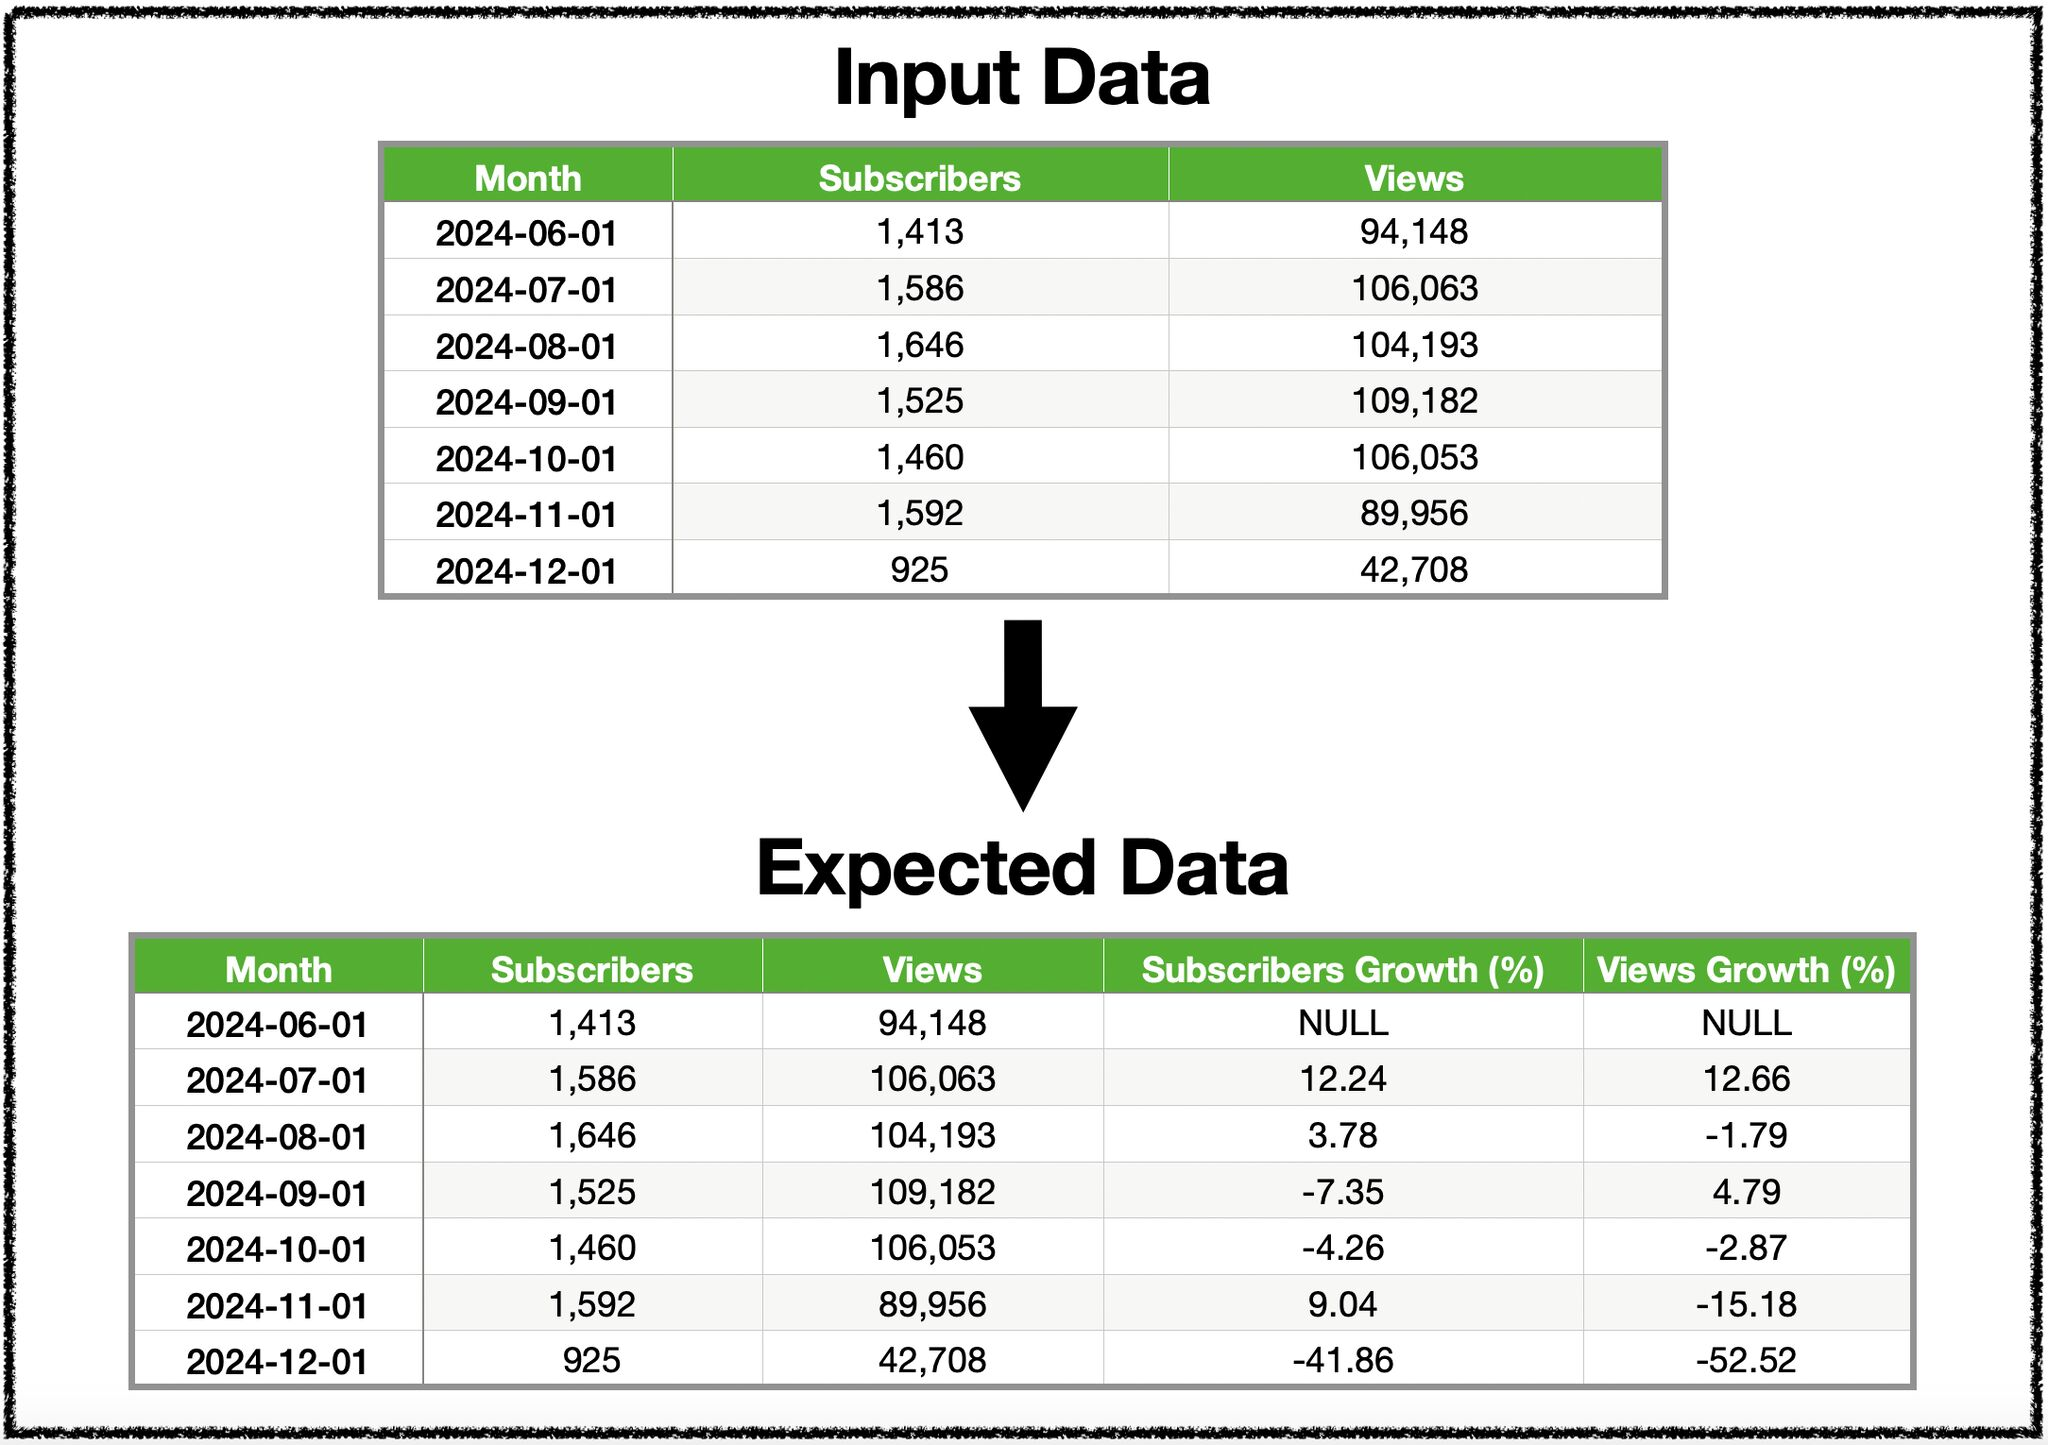



In [41]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lag,round
from pyspark.sql.window import Window


spark = SparkSession.builder.appName("findinggrowthrate").master("local[*]").getOrCreate()

# 𝘚𝘢𝘮𝘱𝘭𝘦 𝘥𝘢𝘵𝘢
𝘥𝘢𝘵𝘢 = [
 ('2024-06-01', 1413, 94148),
 ('2024-07-01', 1586, 106063),
 ('2024-08-01', 1646, 104193),
 ('2024-09-01', 1525, 109182),
 ('2024-10-01', 1460, 106053),
 ('2024-11-01', 1592, 89956),
 ('2024-12-01', 925, 42708)
]

# 𝘊𝘳𝘦𝘢𝘵𝘦 𝘋𝘢𝘵𝘢𝘍𝘳𝘢𝘮𝘦
𝘤𝘰𝘭𝘶𝘮𝘯𝘴 = ("Month", "Subscribers", "Views")
𝘥𝘧 = 𝘴𝘱𝘢𝘳𝘬.𝘤𝘳𝘦𝘢𝘵𝘦𝘋𝘢𝘵𝘢𝘍𝘳𝘢𝘮𝘦(𝘥𝘢𝘵𝘢, 𝘤𝘰𝘭𝘶𝘮𝘯𝘴)

wd = Window.orderBy ("Month")
df1 = df.withColumn("subscribergrowth", round((col("Subscribers")-lag(col("Subscribers"),1).over(wd))/lag(col("Subscribers"),1).over(wd)*100,2))\
        .withColumn("viewgrowth", round((col("Views")-lag(col("Views"),1).over(wd))/lag(col("Views"),1).over(wd)*100,2))
df1.show()

+----------+-----------+------+----------------+----------+
|     Month|Subscribers| Views|subscribergrowth|viewgrowth|
+----------+-----------+------+----------------+----------+
|2024-06-01|       1413| 94148|            NULL|      NULL|
|2024-07-01|       1586|106063|           12.24|     12.66|
|2024-08-01|       1646|104193|            3.78|     -1.76|
|2024-09-01|       1525|109182|           -7.35|      4.79|
|2024-10-01|       1460|106053|           -4.26|     -2.87|
|2024-11-01|       1592| 89956|            9.04|    -15.18|
|2024-12-01|        925| 42708|           -41.9|    -52.52|
+----------+-----------+------+----------------+----------+

